# Projeto 3 de Modelagem Matemática: Epidemiologia

#### Leonardo Bohac (entregue em 19/05/2019)

Neste Projeto será feito um ajuste para dados de epidemiologia, assim como uma minimização do custo associado ao modelo de propagação e tratamento epidêmico proposto.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### 1. Modelo SIR

Na célula abaixo está programada, de forma sequencial, a evolução do número de habitantes *Suscetíveis, Infectados e Recuperados* na existência de uma doença na população.

In [2]:
def SIR_System_Evoltution(Beta, Gamma):

    # Os parâmetros iniciais são relativos ao caso de Influenza em uma escola ao norte da Inglaterra
    
    N = 763

    SIR = [[762, 1, 0]]

    dt = 1e-2

    for l in range(1400):
    
        S = SIR[-1][0]
        I = SIR[-1][1]
    
        dS = -Beta * (1/N) * I * S * dt
    
        dI = (Beta * (1/N) * I * S - Gamma * I) * dt
    
        nS = S + dS
    
        nI = I + dI
    
        nR = N - (nS + nI)
    
        SIR.append([nS, nI, nR])
    
    
    SIR = np.array(SIR)[::int(1/dt)]   # discretização em dias
    
    return SIR

O número real de dis(do)centes infectados ao longo das duas semanas:

In [3]:
Real_I = np.array([1,3,7,25,72,222,282,256,233,189,123,70,25,11,4])

Abaixo é feita uma busca em um pequeno subespaço de $\;\mathbb{R}^{2}\;$ dos parâmetros $\;\beta\;$ e $\;\gamma\;$ que melhor se ajustam aos dados observados.

In [4]:
Min_Error = 1e6

for Beta in np.linspace(0, 2, 40):
    
    for Gamma in np.linspace(0, 1, 40):
        
        SIR = SIR_System_Evoltution(Beta, Gamma)
        
        I = SIR[:,1]
        
        Error = sum(abs(I - Real_I))
        
        if(Error < Min_Error):
            
            Min_Error  = Error
            
            Best_Beta  = Beta
            
            Best_Gamma = Gamma
            
            Best_SIR = SIR

In [5]:
Best_Beta, Best_Gamma

(1.641025641025641, 0.4358974358974359)

Comparando o número real de infectados com o número de infectados inferido:

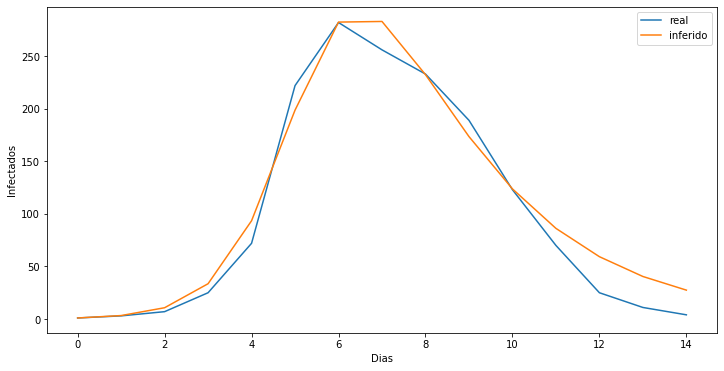

In [6]:
plt.figure(figsize=(12,6))

plt.xlabel('Dias')
plt.ylabel('Infectados')

plt.plot(Real_I, label='real')
plt.plot(Best_SIR[:,1], label='inferido')

plt.legend();

Gráfico da evolução do modelo inferido:

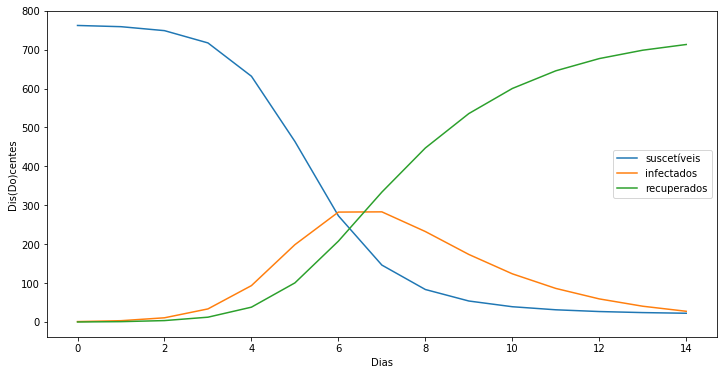

In [7]:
plt.figure(figsize=(12,6))

plt.xlabel('Dias')
plt.ylabel('Dis(Do)centes')

plt.plot(Best_SIR[:,0], label='suscetíveis')
plt.plot(Best_SIR[:,1], label='infectados')
plt.plot(Best_SIR[:,2], label='recuperados')

plt.legend();

### 2. SIR com vacinação / Minimização do custo

Na célula abaixo está programada a evolução do número de habitantes *Suscetíveis, Infectados e Recuperados* de acordo com o modelo SIR, agora levando em consideração novos parâmetros de mortalidade/natalidade e imunização na população.

In [8]:
def Vaccine_SIR_System_Evoltution(Beta, Gamma, Nu, U):

    N = 1000    # definindo uma população inicial de 1000 habitantes

    V_SIR = [[N-100, 100, 0]]   # 10% da população inicial infectada 

    dt = 1e-2

    a  = U[0]
    b  = U[1]
    c  = U[2]
    t1 = U[3]
    t2 = U[4]
    
    for l in range(9900):
    
        t = int(l * dt)
        
        if(t < t1)  : u = a 
        
        elif(t < t2): u = b
             
        else        : u = c
            
            
        S = V_SIR[-1][0]
        I = V_SIR[-1][1]
        R = V_SIR[-1][2]
        
        dS = (Nu*N - Beta*(1/N)*I*S - u*S - Nu*S) * dt
    
        dI = (Beta*(1/N)*I*S - Gamma*I - Nu*I) * dt
        
        dR = (Gamma*I + u*S - Nu*R) * dt
    
        
        nS = S + dS
    
        nI = I + dI
    
        nR = R + dR
    
        
        V_SIR.append([nS, nI, nR])
    
    
    V_SIR = np.array(V_SIR)[::int(1/dt)]
    
    return V_SIR

Abaixo está programado o cálculo do Funcional-Custo relativo à estratégia de vacinação $(U)$ utilizada.

In [9]:
def J(U):
    
    a  = U[0]
    b  = U[1]
    c  = U[2]
    t1 = U[3]
    t2 = U[4]
    
    u = np.zeros(100)
    
    u[:t1]   = np.full(t1, a)

    u[t1:t2] = np.full(t2-t1, b)

    u[t2:]   = np.full(100-t2, c)
    
    Nu = 0.2
    
    Vaccine_SIR = Vaccine_SIR_System_Evoltution(Best_Beta, Best_Gamma, Nu, U)
    
    S = Vaccine_SIR[:,0]
    I = Vaccine_SIR[:,1]
    
    A1 = 0.1
    A2 = 1.0
    
    Tau = 50
    
    return sum(A1*S + A2*I + (Tau/2)*u**2)

A fim de encontrar o mínimo do funcional, podemos fazer uma busca randomizada dentro do espaço de funções admissíveis.

*obs: Apesar de não ser um método de otimização elaborado, buscar randômicamente se mostrou uma alternativa válida neste caso. O espaço de funções é razoavelmente pequeno (da ordem de $10^{9}$, considerando um erro de $1\%$ nos parâmetros). Além disso, a diferença do custo mínimo que encontrei em diversas buscas, algumas curtas e outras muito longas, foi insignificante (~$0.5\%$), indicando a existência de uma miríade de bons mínimos locais*.

In [10]:
# Algoritmo de busca aleatória no espaço de funções admissíveis

def Random_Search_U():
    
    Min_Functional = 1e6
    
    for search in range(500):        # este número define a extensão da busca (como foi dito, aumentá-lo não traz ganhos significativos)
        
        a  = np.random.uniform(0, 0.9)
        
        b  = np.random.uniform(0, 0.9)
        
        c  = np.random.uniform(0, 0.9)
        
        t1 = np.random.randint(1, 100)
        
        t2 = np.random.randint(t1+1, 101)
        
        U = [a, b, c, t1, t2]
        
        Functional = J(U)
        
        if(Functional < Min_Functional):
            
            Min_Functional = Functional
            
            Good_U = U
        
    return Good_U

Fazendo a busca:

In [11]:
np.random.seed(100)

U = Random_Search_U()

U

[0.8625268423092903, 0.5515821069158542, 0.5078948408392938, 16, 93]

Funcional-Custo:

In [12]:
J(U)

4178.482012586682

Visualizando os resultados:

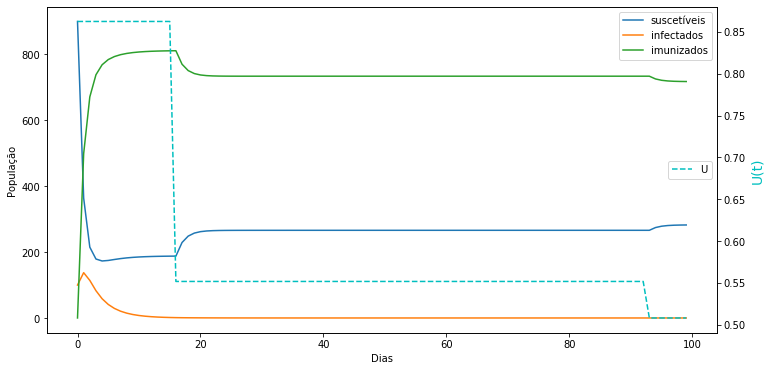

In [13]:
Vaccine_SIR = Vaccine_SIR_System_Evoltution(Best_Beta, Best_Gamma, 0.2, U)

fig, ax1 = plt.subplots(figsize=(12,6))

ax1.set_xlabel('Dias')
ax1.set_ylabel('População')

ax1.plot(Vaccine_SIR[:,0], label='suscetíveis')
ax1.plot(Vaccine_SIR[:,1], label='infectados')
ax1.plot(Vaccine_SIR[:,2], label='imunizados')


ax2 = ax1.twinx()

a  = U[0]
b  = U[1]
c  = U[2]
t1 = U[3]
t2 = U[4]
    
u = np.zeros(100)
    
u[:t1]   = np.full(t1, a)

u[t1:t2] = np.full(t2-t1, b)

u[t2:]   = np.full(100-t2, c)


ax2.set_ylabel('U(t)', color='c', fontsize=14)

ax2.plot(u, 'c--',label='U')


ax1.legend(loc=0);
ax2.legend(loc=5);